<a href="https://colab.research.google.com/github/partha1189/machine_learning/blob/master/DNNTimeSeries.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
print(tf.__version__)

2.3.0


In [2]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

def trend(time, slope=0):
    return slope * time

def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

time = np.arange(4 * 365 + 1, dtype="float32")
baseline = 10
series = trend(time, 0.1)  
baseline = 10
amplitude = 20
slope = 0.09
noise_level = 5

# Create the series
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)
# Update with noise
series += noise(time, noise_level, seed=42)

split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

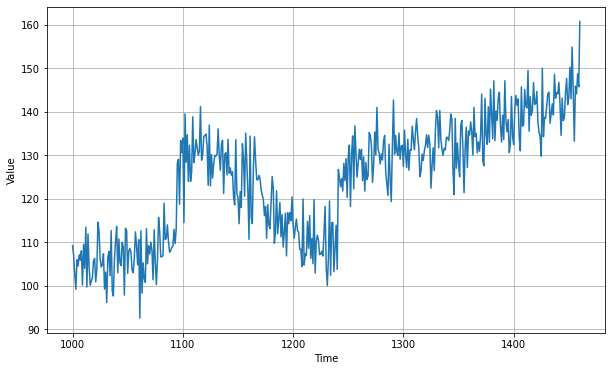

In [3]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)

In [4]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(window_size + 1, shift = 1, drop_remainder = True)
  dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
  dataset = dataset.shuffle(shuffle_buffer).map(lambda window : (window[:-1], window[-1]))
  dataset = dataset.batch(batch_size).prefetch(1)
  return dataset

In [5]:
dataset = windowed_dataset(series, window_size, batch_size, shuffle_buffer_size)

In [6]:
dataset

<PrefetchDataset shapes: ((None, None), (None,)), types: (tf.float32, tf.float32)>

In [7]:
for window_dataset in dataset:
  for val in window_dataset:
    print(val.numpy(), end=' ')
  print()

Streaming output truncated to the last 5000 lines.
 [ 65.77846   62.086437  61.763447  62.094616  66.28589   62.265194
   65.87576   74.86093   68.89685   62.96869   70.66272   62.674374
   54.582493  59.79131   55.536667  63.192192  65.10124   73.45097
   66.763306  64.0933  ]
 [130.0783   134.28056  134.50398  134.8552   132.05202  123.076385
  136.88637  122.91007  130.0724   124.70018  128.05814  129.92493
  129.78525  130.18053  136.02711  130.1091   126.498825 132.41357
  133.40944  121.18849 ]
 [ 98.62211  104.68338  100.87476  101.50936  102.13909  101.593666
  102.63381  106.13124  100.53356  103.16166   99.23384  106.94918
   96.432915 108.88604   99.74721   92.86098  100.72242   96.743866
  104.419754  97.02101 ]
 [ 71.379364  73.87619   69.232025  76.61587   63.430172  61.143265
   58.540535  74.98214   70.84171   67.36011   69.10619   62.147404
   80.072296  68.558495  68.52839   71.679436  70.525024  69.30894
   64.30685   70.68643 ]
 [ 64.05696   58.283886  66.045906  54

In [8]:
model = tf.keras.models.Sequential([
     tf.keras.layers.Dense(10, input_shape= [window_size], activation='relu'),
     tf.keras.layers.Dense(10, activation='relu'),
     tf.keras.layers.Dense(1)
])

In [9]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 10)                210       
_________________________________________________________________
dense_1 (Dense)              (None, 10)                110       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 11        
Total params: 331
Trainable params: 331
Non-trainable params: 0
_________________________________________________________________


In [10]:
model.compile(loss='mse', optimizer=tf.keras.optimizers.SGD(lr=1e-6, momentum=0.9))
model.fit(dataset, epochs=100, verbose=0)

In [11]:
forecast = []
for time in range(len(series) - window_size):
  forecast.append(model.predict(series[time: time + window_size][np.newaxis]))
forecast = forecast[split_time - window_size : ]

In [12]:
forecast[:10]

[array([[100.34353]], dtype=float32),
 array([[101.21722]], dtype=float32),
 array([[102.895386]], dtype=float32),
 array([[102.50325]], dtype=float32),
 array([[101.60071]], dtype=float32),
 array([[101.06646]], dtype=float32),
 array([[104.13418]], dtype=float32),
 array([[103.98875]], dtype=float32),
 array([[103.57112]], dtype=float32),
 array([[103.48711]], dtype=float32)]

In [16]:
print(np.array(forecast[2]))

[[102.895386]]


In [20]:
print(np.array(forecast[2])[0, 0])

102.895386


In [21]:
results = np.array(forecast)[:, 0, 0]

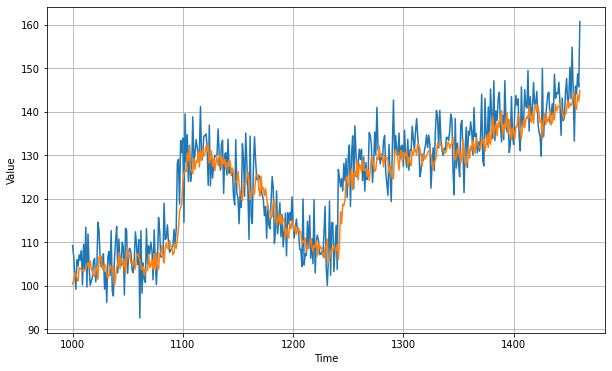

In [22]:
plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [23]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

4.6682673

In [24]:
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(10, input_shape=[window_size], activation="relu"), 
    tf.keras.layers.Dense(10, activation="relu"), 
    tf.keras.layers.Dense(1)
])

Learning Rate Scheduler

In [25]:
lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-8 * 10**(epoch/20))
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss='mse', optimizer=optimizer)
history = model.fit(dataset, epochs=100, callbacks=[lr_schedule], verbose = 0)

(1e-08, 0.001, 0.0, 300.0)

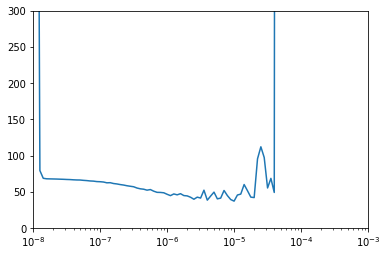

In [26]:
lrs = 1e-8 * (10**(np.arange(100) / 20))
plt.semilogx(lrs, history.history['loss'])
plt.axis([1e-8, 1e-3, 0, 300])

In [27]:
window_size = 30
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model = tf.keras.models.Sequential([
  tf.keras.layers.Dense(10, activation="relu", input_shape=[window_size]),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1)
])

optimizer = tf.keras.optimizers.SGD(lr=8e-6, momentum=0.9)
model.compile(loss="mse", optimizer=optimizer)
history = model.fit(dataset, epochs=500, verbose=0)

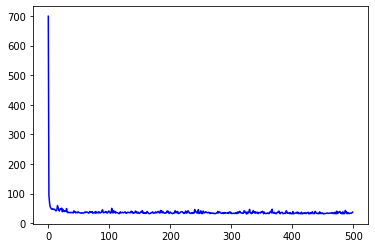

In [28]:
loss = history.history['loss']
epochs = range(len(loss))

plt.plot(epochs, loss, 'b', label = 'Training Loss')
plt.show()

[47.2840690612793, 45.70600128173828, 42.17695999145508, 41.778865814208984, 44.0464973449707, 59.8518180847168, 53.642765045166016, 46.856990814208984, 40.96723556518555, 45.75595474243164, 48.38056182861328, 46.46099090576172, 50.70061111450195, 38.734832763671875, 46.546329498291016, 43.0378532409668, 39.171791076660156, 42.413299560546875, 42.64549255371094, 39.99454879760742, 49.5308837890625, 36.807769775390625, 35.611854553222656, 37.67627716064453, 35.98190689086914, 35.866371154785156, 36.2505989074707, 35.104305267333984, 36.27605438232422, 36.82196807861328, 35.3284912109375, 34.87773513793945, 41.82383346557617, 38.48362350463867, 38.77263641357422, 34.55156707763672, 36.65904998779297, 37.040550231933594, 35.267818450927734, 38.568599700927734, 36.6137580871582, 35.421531677246094, 35.1100959777832, 34.174686431884766, 33.83051300048828, 35.533668518066406, 34.50051498413086, 34.159637451171875, 34.39250564575195, 35.483619689941406, 37.9748420715332, 36.03254318237305, 37

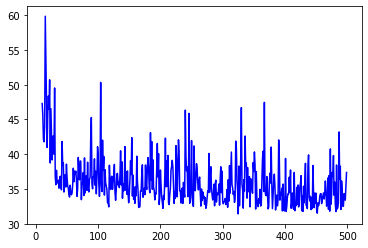

In [29]:
# Plot all but the first 10
loss = history.history['loss']
epochs = range(10, len(loss))
plot_loss = loss[10:]
print(plot_loss)
plt.plot(epochs, plot_loss, 'b', label='Training Loss')
plt.show()

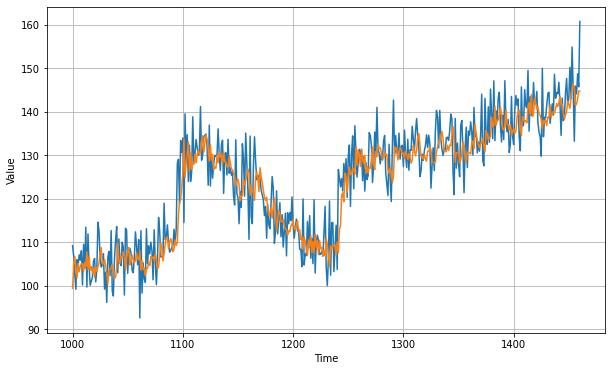

In [30]:
forecast = []
for time in range(len(series) - window_size):
  forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]


plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [31]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

4.5708594